In [2]:
from transformers import pipeline
from nltk import sent_tokenize
import nltk
import torch
from glob import glob
import pandas as pd
import numpy as np

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Yash\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load model

In [4]:
model_name = "facebook/bart-large-mnli"
device = 0 if torch.cuda.is_available() else 'cpu'

In [5]:
def load_model(device):
    theme_classifier = pipeline(
        "zero-shot-classification",
        model=model_name,
        device=device
    )

    return theme_classifier

In [6]:
theme_classifier = load_model(device)

c:\Users\Yash\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
theme_list = ["friendship", "hope", "sacrifice", "battle", "self development", "betrayal", "love", "dialogue"]

In [8]:
theme_classifier(
    "The love is most supreme in the world",
    theme_list
)

{'sequence': 'The love is most supreme in the world',
 'labels': ['love',
  'dialogue',
  'self development',
  'sacrifice',
  'hope',
  'friendship',
  'battle',
  'betrayal'],
 'scores': [0.9734795689582825,
  0.008262718096375465,
  0.0055749667808413506,
  0.004337860271334648,
  0.003277836600318551,
  0.002633810741826892,
  0.0017045695567503572,
  0.0007285932078957558]}

# Load dataset

In [9]:
files = glob("../data/Subtitles/*.ass")

In [10]:
files[:5]

['../data/Subtitles\\Naruto Season 1 - 01.ass',
 '../data/Subtitles\\Naruto Season 1 - 02.ass',
 '../data/Subtitles\\Naruto Season 1 - 03.ass',
 '../data/Subtitles\\Naruto Season 1 - 04.ass',
 '../data/Subtitles\\Naruto Season 1 - 05.ass']

In [11]:
with open(files[0], 'r') as file:
    lines = file.readlines()
    lines = lines[27:]
    lines = [",".join(line.split(',')[9:]) for line in lines]

In [12]:
lines[:2]

['A long time ago, a powerful demon fox\\Nappeared with nine tails.\n',
 'With its powerful tails,\n']

In [13]:
lines = [line.replace('\\N', ' ') for line in lines]

In [14]:
lines[:2]

['A long time ago, a powerful demon fox appeared with nine tails.\n',
 'With its powerful tails,\n']

In [15]:
def load_subtitles_dataset(dataset_path):
    subtitles_path = glob(dataset_path + '/*.ass')

    scripts = []
    episode_num = []

    for path in subtitles_path:

        # Read lines
        with open(path, 'r') as file:
            lines = file.readlines()
            lines = lines[27:]
            lines = [",".join(line.split(',')[9:]) for line in lines]
        
        # Clean data
        lines = [line.replace('\\N', ' ') for line in lines]
        script = " ".join(lines)

        episode = int(path.split('-')[-1].split('.')[0].strip())

        scripts.append(script)
        episode_num.append(episode)

    df = pd.DataFrame.from_dict({"episode": episode_num, "script": scripts})
    return df

In [16]:
dataset_path = "../data/Subtitles"
df = load_subtitles_dataset(dataset_path)

In [17]:
df.head()

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."
2,3,"C'mon!\n Running like a fugitive,\n Being chas..."
3,4,"C'mon!\n Running like a fugitive,\n Being chas..."
4,5,"C'mon!\n Running like a fugitive,\n Being chas..."


Run model

In [18]:
script = df.iloc[0]['script']

In [19]:
script

'A long time ago, a powerful demon fox appeared with nine tails.\n With its powerful tails,\n it could smash mountains and create tidal waves.\n A band of Ninjas rose to defend their village from attack.\n We have to wait until the Fourth Hokage gets here!\n We can\'t let it get any closer to our village!\n One great Ninja was able to imprison the monster,\n but died in the process.\n This Ninja was known as… the Fourth Hokage.\n Naruto!\n Why did you do such a thing?!\n You\'re really gonna get it this time!\n I don\'t care!\n You know your problem?\n You can\'t do the things I do!\n Only I can do this!\n I\'m better than all of you! Believe it!\n There\'s a problem, sir!\n Lord Hokage!\n What is it?\n Did that Naruto do something again?\n Yes. He climbed onto the Mountainside Images…\n And he vandalized and graffitied all over them!\n Wait!\n Ha ha…\n Why should I?\n Hey, Naruto!\n How did you suddenly get here, lruka Sensei?\n The question is what are you doing here when you should 

In [20]:
script_sentences = sent_tokenize(script)
script_sentences[:3]

['A long time ago, a powerful demon fox appeared with nine tails.',
 'With its powerful tails,\n it could smash mountains and create tidal waves.',
 'A band of Ninjas rose to defend their village from attack.']

In [21]:
sentence_batch_size = 20
script_batches = []
for index in range(0, len(script_sentences), sentence_batch_size):
    sent = " ".join(script_sentences[index : index + sentence_batch_size])
    script_batches.append(sent)

In [22]:
script_batches[:2]

["A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?",
 'Yes. He climbed onto the Mountainside Images…\n And he vandalized and graffitied all over them! Wait! Ha ha…\n Why should I? Hey, Naruto! How did you suddenly get here, lruka Sensei? The question is what are you doing here when you should be in class now? Now listen, Naruto. You failed t

In [23]:
theme_output = theme_classifier(
    script_batches[:2],
    theme_list
)

In [24]:
theme_output

[{'sequence': "A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?",
  'labels': ['dialogue',
   'betrayal',
   'battle',
   'sacrifice',
   'self development',
   'hope',
   'friendship',
   'love'],
  'scores': [0.40400242805480957,
   0.21849457919597626,
   0.11749247461557388,
   0.09763026982545853,
   0.08557643741369247,
   0.0366485863

In [25]:
# Wrangle output
themes = {}
for output in theme_output:
    for label,score in  zip(output['labels'], output['scores']):
        if label not in themes:
            themes[label] = []
        themes[label].append(score)

In [26]:
themes

{'dialogue': [0.40400242805480957, 0.36811572313308716],
 'betrayal': [0.21849457919597626, 0.0979030430316925],
 'battle': [0.11749247461557388, 0.10354545712471008],
 'sacrifice': [0.09763026982545853, 0.10923676192760468],
 'self development': [0.08557643741369247, 0.2229234278202057],
 'hope': [0.03664858639240265, 0.044888079166412354],
 'friendship': [0.02255195379257202, 0.03382037207484245],
 'love': [0.017603259533643723, 0.019567087292671204]}

In [27]:
def get_themes_inference(script):
    script_sentences = sent_tokenize(script)

    # Batch sentences
    sentence_batch_size = 20
    script_batches = []
    for index in range(0, len(script_sentences), sentence_batch_size):
        sent = " ".join(script_sentences[index : index + sentence_batch_size])
        script_batches.append(sent)

    # Run model
    theme_output = theme_classifier(
        script_batches[:2],
        theme_list
    )

    # Wrangle output
    themes = {}
    for output in theme_output:
        for label,score in  zip(output['labels'], output['scores']):
            if label not in themes:
                themes[label] = []
            themes[label].append(score)
    
    themes = {key: np.mean(np.array(value)) for key,value in themes.items()}

    return themes

In [28]:
df = df.head(2)

In [29]:
df

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."


In [30]:
output_themes = df['script'].apply(get_themes_inference)

In [31]:
output_themes

0    {'dialogue': 0.38605907559394836, 'betrayal': ...
1    {'dialogue': 0.5243559628725052, 'sacrifice': ...
Name: script, dtype: object

In [32]:
theme_df = pd.DataFrame(output_themes.tolist())

In [33]:
theme_df

,dialogue,betrayal,battle,sacrifice,self development,hope,friendship,love
0,0.386059,0.158199,0.110519,0.103434,0.154250,0.040768,0.028186,0.018585
1,0.524356,0.057775,0.125403,0.096477,0.079192,0.055344,0.022947,0.038506


In [34]:
df

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."


In [35]:
df[theme_df.columns] = theme_df
df

,episode,script,dialogue,betrayal,battle,sacrifice,self development,hope,friendship,love
0,1,"A long time ago, a powerful demon fox appeared...",0.386059,0.158199,0.110519,0.103434,0.154250,0.040768,0.028186,0.018585
1,2,"C'mon!\n Running like a fugitive,\n Being chas...",0.524356,0.057775,0.125403,0.096477,0.079192,0.055344,0.022947,0.038506


# Visualize Output

In [41]:
df.drop('dialogue', axis=1)
df

,episode,script,dialogue,betrayal,battle,sacrifice,self development,hope,friendship,love
0,1,"A long time ago, a powerful demon fox appeared...",0.386059,0.158199,0.110519,0.103434,0.154250,0.040768,0.028186,0.018585
1,2,"C'mon!\n Running like a fugitive,\n Being chas...",0.524356,0.057775,0.125403,0.096477,0.079192,0.055344,0.022947,0.038506


In [42]:
theme_output = df.drop(['episode', 'script', 'dialogue'], axis=1).sum().reset_index()
theme_output.columns = ['theme', 'score']
theme_output

,theme,score
0,betrayal,0.215974
1,battle,0.235922
2,sacrifice,0.199910
3,self development,0.233442
4,hope,0.096112
5,friendship,0.051133
6,love,0.057091


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

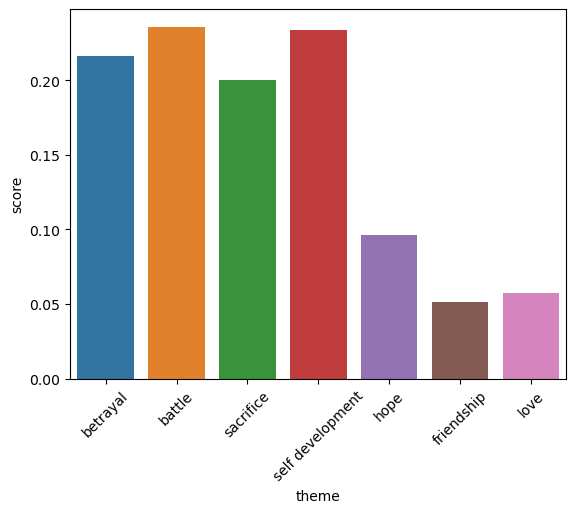

In [45]:
sns.barplot(data= theme_output, x='theme', y='score')
plt.xticks(rotation=45)
plt.show()